# Predicting Hardness

### Imports

In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

PyTorch package version 1.0.1 was used.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

In [3]:
from sklearn.model_selection import train_test_split

### Classes and functions

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true)* var_H +mean_H, np.array(y_pred)* var_H +mean_H
    res = []
    for i in range(len(y_true)):
        if y_true[i] != 0.:
            res.append(np.abs((y_true[i] - y_pred[i]) / y_true[i]))
    return np.mean(res) * 100

In [13]:
def get_errors(test_data, predicted_data):
    """ Different error estimates.
    """
    # Total variance
    SSt_DNN = np.sum(np.square(test_data-np.mean(test_data)))
    # Residual sum of squares
    SSr_DNN = np.sum(np.square(predicted_data-test_data))
    # Root-mean-square error
    RMSE_DNN = np.sqrt(np.sum(np.square(predicted_data-test_data)))
    # R^2 coefficient
    r2_DNN = 1-(SSr_DNN/SSt_DNN)
    MAPE = mean_absolute_percentage_error(test_data, predicted_data)
    return RMSE_DNN, r2_DNN, MAPE

In [ ]:
def generate_X_perm(X_orig, data_to_select, feature_ind):
    """ Helper function to generate random data for importance check
    """
    new_X = np.copy(X_orig)
    mu, sigma = np.mean(X_orig[:,feature_ind]), np.std(X_orig[:,feature_ind])
    new_X[:,feature_ind] = np.random.normal(mu, sigma, X_orig.shape[0])
    return new_X

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    Based on https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int, default = 7): 
                How long to wait after last time validation loss improved.
            verbose (bool, default = False): 
                If True, prints a message for each validation loss improvement. 
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print('Validation loss decreased ('+str(self.val_loss_min)+' --> '+str(val_loss)+'.  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint_.pt')
        self.val_loss_min = val_loss


In [14]:
class Net(torch.nn.Module):
    """ Neural network architecture used for prediction.
    """
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [5]:
def train_and_val(X, Y, n_neurons, test_size =0.2, silent = False):
    """ Fuction to train and validate the neural network 
        of a class Net (linear input and output activation functions,
        one hidden layer with tanh).
    
    Args:
        X (numpy array): 
            normilized input for training and validation;
        Y (numpy array):
            corresponding output for training and validation;
        n_neurons (int):
            the size of a hidden layer;
        test_size (float, default = 0.2): 
            which percent of the data to use for validation (values between 0.0 and 1.0);
        silent (bool, default = False): 
            If True, prints messages.
    Returns:
        Net: 
            trained neural network;
        float:
            R^2 coefficient for validation data;
        float:
            value of loss function for the validation data;
        float:
            value of loss function for the training data;
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    y_train=y_train.reshape(y_train.size,1)

    y_test=y_test.reshape(y_test.size,1)
    
    x = torch.from_numpy(X_train).float()
    y = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(X_test).float()
    y_val = torch.from_numpy(y_test).float()

    net = Net(n_feature=X_train.shape[1], n_hidden=n_neurons, n_output=y_train.shape[1]) # define the network
    if not silent: print(net)  # net architecture

    loss_func = torch.nn.SmoothL1Loss()  # loss function
    optimizer = optim.LBFGS(net.parameters(), lr=0.8) # optimization algorithm

    plt.ion()   # something about plotting

    loss_train = []
    loss_test = []

    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    patience = 5
    n_epochs = 20
    early_stopping = EarlyStopping(patience=patience)
    for t in range(n_epochs):
        if not silent: print('STEP: ', t)
        def closure():
            optimizer.zero_grad()
            out = net(x)
            loss = loss_func(out, y)
            #print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)

        with torch.no_grad():
            prediction = net(x_val)
            loss = loss_func(prediction, y_val)
            pr = net(x)
            loss_tr = loss_func(pr, y)
            loss_train.append(loss_tr.item())
            if not silent: print('train loss:', loss_tr.item())
            loss_test.append(loss.item())
            if not silent: print('test loss:', loss.item())

        if not silent: print("[ "+str(t)+"/"+str(n_epochs)+"] train_loss: "+str(loss_train[t])+ " valid_loss: "+str(loss_test[t]))

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(loss_test[t], net)

        if early_stopping.early_stop:
                if not silent: print("Early stopping")
                break

        

        if t % 1 == 0:
            # plot and show learning process at each step (replace 1 with other number of steps)
            if not silent:
                plt.cla()
                plt.plot(y_val.data.numpy()[:100])
                plt.plot(prediction.data.numpy()[:100])
                plt.show()
                plt.plot(y.data.numpy()[:200])
                plt.plot(pr.data.numpy()[:200])
                plt.show()
                plt.scatter(y_val.data.numpy(), prediction.data.numpy())
                plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
                plt.pause(0.1)
    if not silent:
        plt.ioff()
        plt.show()
    
    _, r2, _ = get_errors(y_val.data.numpy(), prediction.data.numpy())
    
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint_.pt'))

    l_v = loss_func(net(x_val), y_val).item()
    l_tr = loss_func(net(x), y).item()

    
    return net, r2, l_v, l_tr


In [6]:
def predict_all_tooth(data_path, elements_names, model):
    """ Predict the whole tooth surface using trained network.
    
    Args:
            data_path (str): 
                path to the measurments of the elements content. 
                Files must be named element_name.txt (e.g. Ca.txt)
            elements_names (list): 
                the list of strings with names of elements
            model (Net): 
                trained neural network
            
    Returns:
            numpy array: 
                prediction reshaped to the tooth shape
            numpy array: 
                not reshaped predictions           
    
    """
    #read all data
    read_data = []
    for c in elements_names:
        data = np.genfromtxt(data_path+"/"+str(c)+".txt" )
        size = data.shape
        read_data.append(data.ravel())
    
    read_data = np.array(read_data).T
    
    data_mask = np.zeros(read_data.shape[0])
    read_data_new = []
    for i in range(len(read_data)):
        if len(np.where(read_data[i] > 0.)[0]) > 3:
            read_data_new.append(read_data[i])
            data_mask[i] = 1
            
    read_data_new = (np.array(read_data_new) - mean_X)/var_X
    
    y_p = model(torch.from_numpy(read_data_new).float())
    
    y_pr = y_p.data.numpy()
        
    rebuilded = np.zeros(read_data.shape[0])
    count = 0
    for i in range(len(data_mask)):
        if data_mask[i] != 0: 
            rebuilded[i] = y_pr[count]
            count += 1  
            
    rebuilded_new = rebuilded.reshape(size)
    
    return rebuilded_new, y_pr

In [546]:
def save_pred_results(save_folder, array_pred, N, species_name):
    """ Helper function to save the results of predictions. """
    
    for i in range(len(array_pred)):
        np.savetxt(save_folder+"pred_"+species_name+"/pred_"+str(i)+"_N_"+str(N)+".txt", array_pred[i], fmt='%.7f', delimiter=',')
    
    np.savetxt(save_folder+"mean_pred_"+species_name+"_N_"+str(N)+".txt", np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')
    np.savetxt(save_folder+"std_pred_"+species_name+"_N_"+str(N)+".txt", np.std(array_pred[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_20colors.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    #plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_20colors_nomax.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 6))
    plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_6colors.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 6))
    #plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_6colors_nomax.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.std(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    plt.colorbar()
    plt.savefig(save_folder+'std_pred_'+species_name+'_N_'+str(N)+'_20colors.png', dpi=300)
    

# Part 1: Using ensembles of neural networks (NN) to predict Hardness

### Load data for training and prediction

In [7]:
elements_names = ['C', 'Ca', 'F', 'Fe', 'Mg', 'Na', 'O', 'P']
species_list = ["AAl", "HCh", "HIs", "HNy", "HSa"]

In [4]:
# path to the training data
source = '/Data/Hardness_Elasticity_EDX_combo_new.csv'

In [15]:
# path to the elements measurment used for prediction
data_folder_all = '/Data_collection/ralf_smooth/'
AAL_data = data_folder_all+'AAl/'
HCh_data = data_folder_all+'HCh/'
HIs_data = data_folder_all+'HIs/'
HNy_data = data_folder_all+'HNy/'
HSa_data = data_folder_all+'HSa/'

In [7]:
data_all = np.genfromtxt(source, delimiter=',', skip_header=1, dtype=float, usecols=(range(5,15)))

In [8]:
Y_H_ = data_all[:,0] # hardness
Y_E_ = data_all[:,1] # elastic modulus
X_ = data_all[:,2:]
mean_H = np.mean(Y_H_)
var_H = np.std(Y_H_)
mean_E = np.mean(Y_E_)
var_E = np.std(Y_E_)
Y_H = (Y_H_- mean_H)/var_H
Y_E = (Y_E_- mean_E)/var_E
mean_X = np.mean(X_,axis=0)
var_X = np.std(X_,axis=0)
X = (X_- mean_X)/var_X

In [8]:
# Path to the folder, where to save the results
save_folder = "/result_H_20200222/"

## Training and saving NNs

We train 500 independent NNs, save them. Each individual predictions are also saved. Only the networks with $R^2 > 0.7$ will be used for final ensemble prediction. The analysis was repeated for different number of neurons (5, 8, 10, 12, 15, 18, 20) and then the performance was compared. The final results are obtained with the 20 neurons in a hidden layer.

In [ ]:
R_2 = []
nets = []
Loss_v = []
pred = []
n_neurons = 20
for i in range(500):
    # train 500 networks
    #print(i)
    net1, R2, loss_v, loss_tr = train_and_val(X, Y_H, n_neurons, test_size =0.2, silent = True)
    # add networks, R^2, loss values for validation 
    nets.append(net1)
    R_2.append(R2)
    Loss_v.append(loss_v)
    torch.save(net1.state_dict(), save_folder+"nets/net_"+str(i)+"_N_"+str(n_neurons))

R2_array = np.array(R_2)
Loss_v_array = np.array(Loss_v)
pr_array = np.array(pred)

np.savetxt(save_folder+"N_"+str(n_neurons)+"_R2_Loss.txt", np.vstack((R2_array, Loss_v_array)).T, fmt='%.7f', delimiter=',', header="R2, Loss")

## Combined R2 and Loss performance

In [19]:
R2_files = []
Loss_files = []
Ns = [5, 8, 10, 12, 15, 18, 20]
for i in Ns:
    tmp = np.genfromtxt(save_folder+'N_'+str(i)+'_R2_Loss.txt', skip_header=1, dtype=float, delimiter=',')
    R2_files.append(tmp[:,0])
    Loss_files.append(tmp[:,1])
R2_all = np.array(R2_files)
Loss_all = np.array(Loss_files)

In [20]:
# replace the values for the failed NN for nicer plots
R2_all[R2_all == -np.inf] = 0.
R2_all[np.isnan(R2_all)]=0.
R2_all[np.where(R2_all < 0) ] = 0.

In [21]:
# replace the values for the failed NN for nicer plots
Loss_all[np.isnan(Loss_all)]=0.3
Loss_all[np.where(Loss_all > 1) ] = 0.3

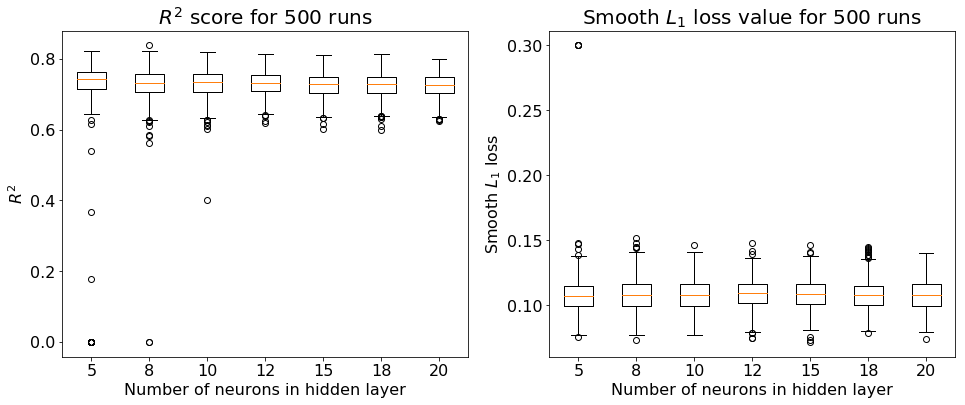

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.boxplot(R2_all.T)
plt.title(r'$R^2$ score for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'$R^2$', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(122)
plt.boxplot(Loss_all.T)
plt.title(r'Smooth $L_1$ loss value for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'Smooth $L_1$ loss', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.savefig(save_folder+'R2_Loss_H.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Predicting and saving teeth surfaces for each species

In [568]:
pred_AAl = []
pred_HCh = []
pred_HIs = []
pred_HNy = []
pred_HSa = []

for net1 in nets:
    
    test_rebuilded_new, pr =  predict_all_tooth(AAl_data, elements_names, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_H + mean_H
    pred_AAl.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HCh_data, elements_names, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_H + mean_H
    pred_HCh.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HIs_data, elements_names, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_H + mean_H
    pred_HIs.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HNy_data, elements_names, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_H + mean_H
    pred_HNy.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HSa_data, elements_names, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_H + mean_H
    pred_HSa.append(test_rebuilded_new)

In [ ]:
save_pred_results(save_folder, np.array(pred_AAl), n_neurons, "AAl")
save_pred_results(save_folder, np.array(pred_HCh), n_neurons, "HCh")
save_pred_results(save_folder, np.array(pred_HIs), n_neurons, "HIs")
save_pred_results(save_folder, np.array(pred_HNy), n_neurons, "HNy")
save_pred_results(save_folder, np.array(pred_HSa), n_neurons, "HSa")

## Make plots of teeth

In [46]:
# read saved data from save_folder
mean_arr = []
std_arr = []
n_neur = 20
for sp in species_list:
    mean_arr.append(np.genfromtxt(save_folder+"mean_pred_"+sp+"_N_"+str(n_neur)+".txt", delimiter=','))
    std_arr.append(np.genfromtxt(save_folder+"std_pred_"+sp+"_N_"+str(n_neur)+".txt", delimiter=','))

In [47]:
# for colorbar boundaries
Max_std = np.max(np.array(std_arr))
Max_mean = np.max(np.array(mean_arr))

In [48]:
color_sc_pred = "jet"
color_sc_std = "afmhot_r"

In [49]:
matplotlib.rc('axes',edgecolor='k')

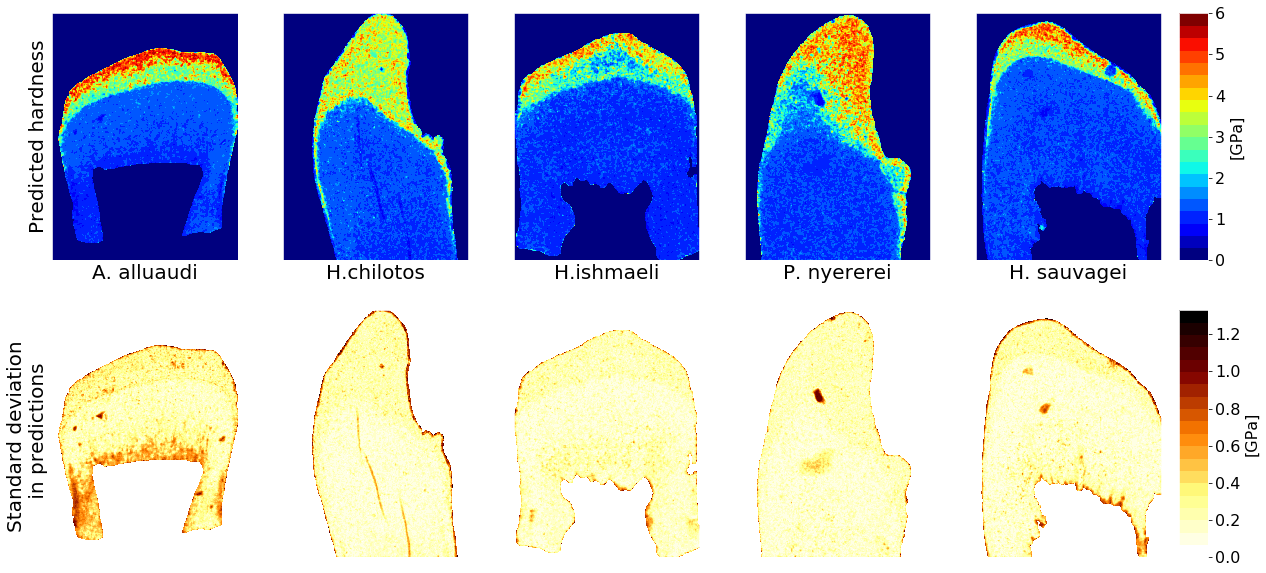

In [50]:
#fig = plt.figure(figsize = (18,10))
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
matplotlib.rc('axes',edgecolor='w')

# AAl
plt.subplot(2,5,1)
plt.imshow(mean_arr[0], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 6)
plt.xlabel('A. alluaudi', fontsize=20)
plt.ylabel('Predicted hardness', fontsize=20)

plt.subplot(2,5,6)
plt.imshow(std_arr[0], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)
plt.ylabel('Standard deviation \n in predictions', fontsize=20)

# HCh
plt.subplot(2,5,2)
plt.imshow(mean_arr[1], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 6)
plt.xlabel('H.chilotos', fontsize=20)

plt.subplot(2,5,7)
plt.imshow(std_arr[1], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HIs
plt.subplot(2,5,3)
plt.imshow(mean_arr[2], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 6)
plt.xlabel('H.ishmaeli', fontsize=20)

plt.subplot(2,5,8)
plt.imshow(std_arr[2], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HNy
plt.subplot(2,5,4)
plt.imshow(mean_arr[3], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 6)
plt.xlabel('P. nyererei', fontsize=20)

plt.subplot(2,5,9)
plt.imshow(std_arr[3], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HSa
plt.subplot(2,5,5)
im1 = plt.imshow(mean_arr[4], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 6)
#plt.colorbar()
plt.xlabel('H. sauvagei', fontsize=20)

plt.subplot(2,5,10)
im2 = plt.imshow(std_arr[4], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)
#plt.colorbar()

cax = plt.axes([0.91, 0.537, 0.02, 0.343])
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(r"[GPa]", size=16)

cax = plt.axes([0.91, 0.125, 0.02, 0.343])
cbar = plt.colorbar(im2, cax=cax)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(r"[GPa]", size=16)


plt.savefig(save_folder+'all_H.png', dpi=300, bbox_inches = 'tight')
plt.show()

# Part 2: Define the infuence of elements of the predictions

## Importance check

In [28]:
# Load saved R^2 values to define the network with maximum R^2
n_neur = 20
R2_orig = np.genfromtxt(save_folder+'N_'+str(n_neur)+'_R2_Loss.txt', skip_header=1, dtype=float, delimiter=',', usecols=0)

In [30]:
# difune the index of the network with maximum R^2
good_NN_inds = np.where(R2_orig == max(R2_orig))[0]

In [32]:
# read the elements' measurments of any of the species to use for random shuffeling
read_data = []
for c in elements_names:
    data = np.genfromtxt(HIs_data+"/"+str(c)+".txt" )
    size = data.shape
    read_data.append(data.ravel())
read_data = np.array(read_data).T

data_mask = np.zeros(read_data.shape[0])
read_data_new = []
for i in range(len(read_data)):
    if len(np.where(read_data[i] > 0.)[0]) > 3:
        read_data_new.append(read_data[i])
        data_mask[i] = 1

read_data_new = (np.array(read_data_new) - mean_X)/var_X

In [35]:
# repeat 500 times the prediction of the network replacing each input by random values
model = Net(8,n_neur,1)
loss_func = torch.nn.SmoothL1Loss()
KK = 500

X_train, X_test, y_train, y_test = train_test_split(X, Y_H, test_size=0.20)
y_test= torch.from_numpy(y_test.reshape(y_test.size,1)).float()

all_err_total = np.zeros((KK, 8))
model.load_state_dict(torch.load(save_folder+'nets/net_'+str(good_NN_inds)+'_N_'+str(n_neur)))
y_pr = model(torch.from_numpy(X_test).float()) 
orig_loss = loss_func(y_test, y_pr.detach()).tolist()
for jj in range(KK):
    all_err1 = np.zeros((X_test.shape[1]))
    for i in range(X_test.shape[1]):
        X_perm = generate_X_perm(X_test, read_data_new, i)
        y_pr = model(torch.from_numpy(X_perm).float())
        all_err1[i] = loss_func(y_test, y_pr.detach()).tolist()
    all_err_total[jj, :] = all_err1/orig_loss#((all_err1/orig_loss) - m_)/(m - m_)


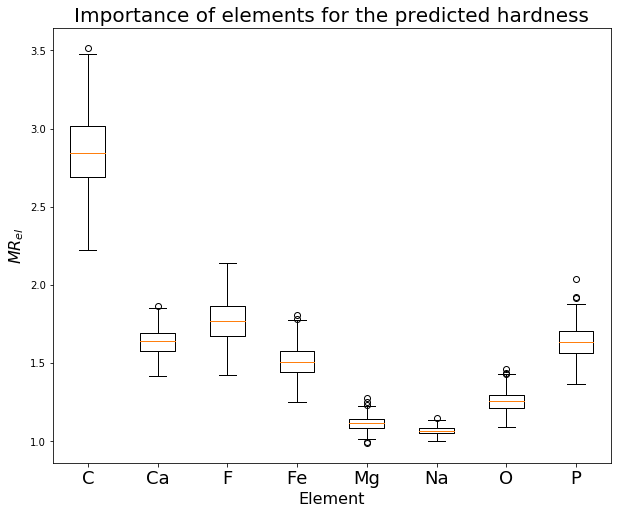

In [41]:
plt.figure(figsize=(10,8))
plt.boxplot(all_err_total)
plt.title("Importance of elements for the predicted hardness", fontsize=20)
plt.xticks(np.arange(len(elements_names))+1, elements_names, fontsize=18)
plt.xlabel("Element", fontsize=16)
plt.ylabel(r'$MR_{el}$', fontsize=16)
plt.savefig(save_folder+'importance_H.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [37]:
np.savetxt(save_folder+'importance_check_1NN_H.txt', all_err_total)

### Plot for publication

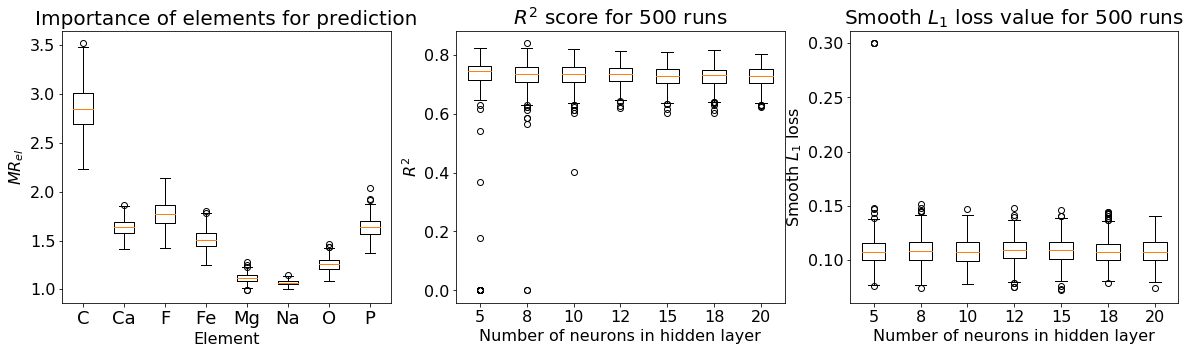

In [40]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.boxplot(all_err_total)
plt.title("Importance of elements for prediction", fontsize=20)
plt.xticks(np.arange(len(elements_names))+1, elements_names, fontsize=18)
plt.xlabel("Element", fontsize=16)
plt.yticks(fontsize = 16)
plt.ylabel(r'$MR_{el}$', fontsize=16)

plt.subplot(132)
plt.boxplot(R2_all.T)
plt.title(r'$R^2$ score for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'$R^2$', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(133)
plt.boxplot(Loss_all.T)
plt.title(r'Smooth $L_1$ loss value for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'Smooth $L_1$ loss', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)


plt.savefig(save_folder+'R2_Loss_Imp_H.png', dpi=300, bbox_inches = 'tight')
plt.show()